In [1]:
import sys

sys.path.insert(0, "..")

from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch

from dinov2.data.masking import MaskingGenerator
from dinov2.data.collate import collate_data_and_cast
from dinov2.data import make_data_loader

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    Mlp,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)


root = "/home/jluesch/Documents/data/cell_imaging_data"
ds_path = f"NPYDataset:split=ALL:root={root}:extra=*"

/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jluesch/micromamba/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submi

In [2]:
data_transform_cpu = DataAugmentationDINO(
    [0.32, 0.8],
    [0.05, 0.32],
    local_crops_number=6,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=True,
    use_native_res=False,
    do_seg_crops=None,
    patch_size=14
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=False,
    cache_dataset=False,
)

Dataset kwargs {'split': <_Split.ALL: 'all'>, 'root': '/home/jluesch/Documents/data/cell_imaging_data', 'extra': '*'}
extra_path /home/jluesch/Documents/data/cell_imaging_data
/home/jluesch/Documents/data/cell_imaging_data/fold*/masks/fold*/masks.npy /home/jluesch/Documents/data/cell_imaging_data/fold*/images/fold*/images.npy
Datasets labels file list: ['/home/jluesch/Documents/data/cell_imaging_data/fold1/masks/fold1/masks.npy', '/home/jluesch/Documents/data/cell_imaging_data/fold2/masks/fold2/masks.npy', '/home/jluesch/Documents/data/cell_imaging_data/fold3/masks/fold3/masks.npy']
Datasets imgs file list: ['/home/jluesch/Documents/data/cell_imaging_data/fold1/images/fold1/images.npy', '/home/jluesch/Documents/data/cell_imaging_data/fold2/images/fold2/images.npy', '/home/jluesch/Documents/data/cell_imaging_data/fold3/images/fold3/images.npy']


In [3]:
dataset

Dataset NPYDataset
    Number of datapoints: 7901
    Root location: /home/jluesch/Documents/data/cell_imaging_data
    StandardTransform
Transform: <dinov2.data.augmentations.DataAugmentationDINO object at 0x7e96c5ec1790>
Target transform: <function <lambda> at 0x7e97842fe820>

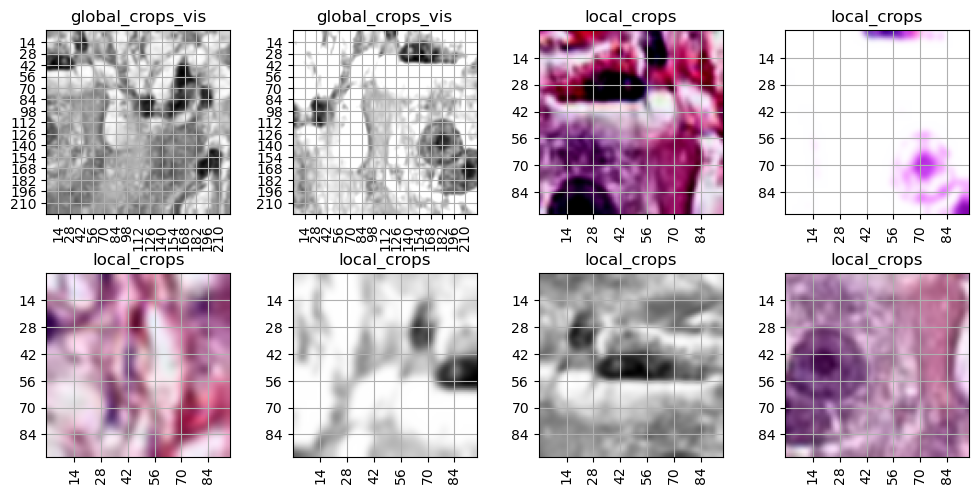

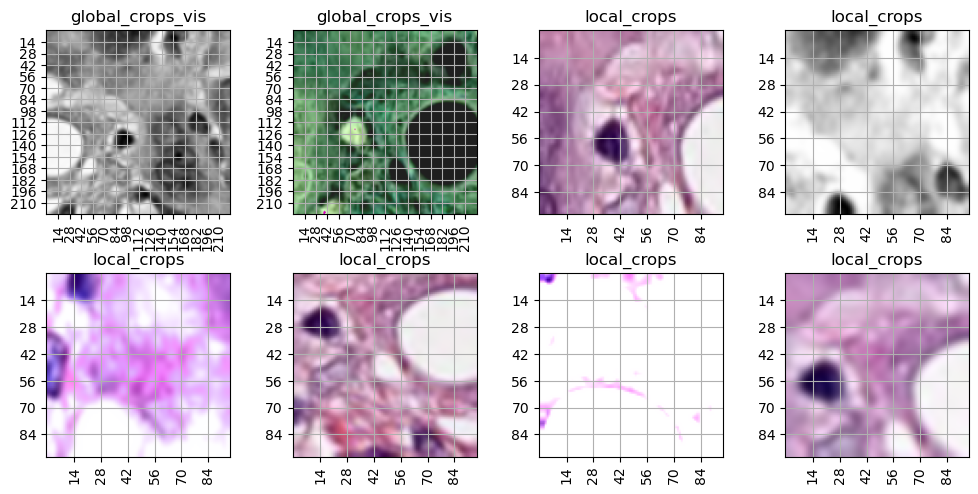

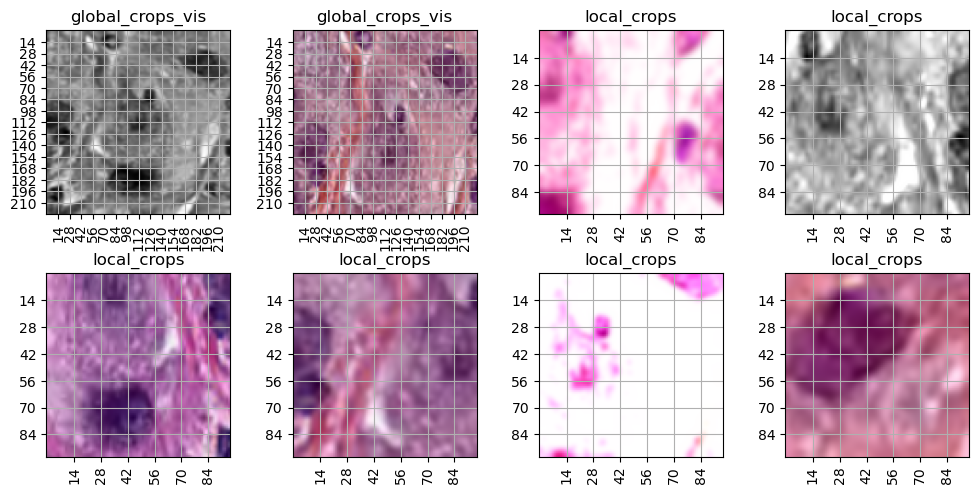

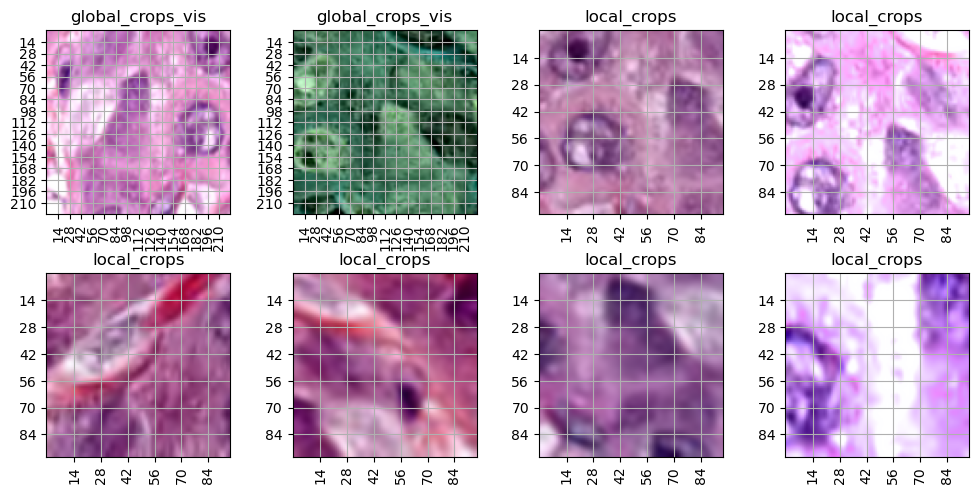

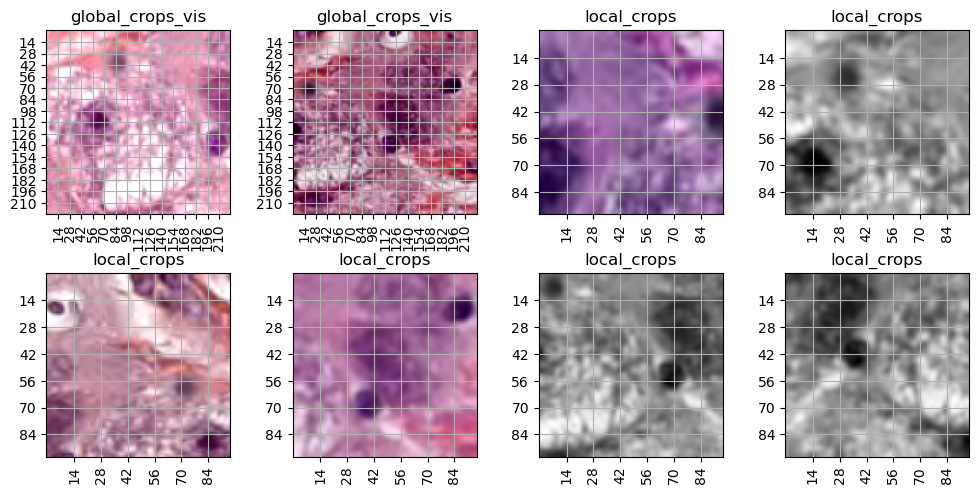

In [5]:
for i in range(5):
    # dict_keys(['global_crops', 'local_crops', 'offsets'])
    imgs = dataset[i][0]

    do_plot = True
    """
    for k in imgs.keys():
        for img in imgs[k]:
            if torch.std(img) < 1e-3:
                print(torch.std(img))
                do_plot = True
                break

        # f2, a2 = plt.subplots(1, 1)
        # plt.hist(img.flatten(), bins=40)
    """
    if do_plot:
        nb_x_plots, nb_y_plots = 2, 4
        f, a = plt.subplots(nb_x_plots, nb_y_plots)
        f.set_size_inches(10, 5)
        f.tight_layout()
        count = 0
        key_list = ["global_crops_vis"]
        if 'local_crops_vis' in imgs.keys():
            key_list +=  ["local_crops_vis"]
        else:
            key_list += ["local_crops"]
        for k in key_list:
            for img in imgs[k]:
                if len(img.shape) > 3:
                    img = img[0]
                if len(img.shape) == 2:
                    img = img[None, :, :].repeat((3, 1, 1))
                #print("img.shape", count, img.shape, ' p shape ', img.permute(1, 2, 0).shape)

                norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
                a[count // 4, count % 4].imshow(norm_img.permute(1, 2, 0))
                a[count // 4, count % 4].set_title(k)
                xticks = np.arange(14, norm_img.shape[2], 14)
                yticks = np.arange(14, norm_img.shape[1], 14)
                a[count // 4, count % 4].set_xticks(xticks)
                a[count // 4, count % 4].set_yticks(yticks)
                a[count // 4, count % 4].xaxis.grid(True)
                a[count // 4, count % 4].yaxis.grid(True)
                a[count // 4, count % 4].set_xticklabels(xticks, rotation=90)
                count += 1
                if count // 4 >= nb_x_plots or count % 4 >= nb_y_plots:
                    break
            else:
                continue  # only executed if the inner loop did NOT break
            break
        if "pooled_seg" in imgs.keys():
            img = imgs["pooled_seg"]
            norm_img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))
            a[-1, -1].imshow(norm_img)
            a[-1, -1].set_title("crops overview")
            colors = ["r", "g", "b", "y", "k", "m", "c", "w"]
            for i, bbox in enumerate(imgs["bboxes"]):
                a[-1, -1].plot(
                    [bbox[0], bbox[2]],
                    [bbox[1], bbox[1]],
                    colors[i % len(colors)],
                    lw=1,
                    label=i,
                )
                a[-1, -1].plot(
                    [bbox[0], bbox[2]],
                    [bbox[3], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )
                a[-1, -1].plot(
                    [bbox[0], bbox[0]],
                    [bbox[1], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )
                a[-1, -1].plot(
                    [bbox[2], bbox[2]],
                    [bbox[1], bbox[3]],
                    colors[i % len(colors)],
                    lw=1,
                )

            xticks = np.arange(14, norm_img.shape[1], 14)
            yticks = np.arange(14, norm_img.shape[0], 14)
            a[-1, -1].set_xticks(xticks)
            a[-1, -1].set_yticks(yticks)
            a[-1, -1].set_xticklabels(xticks, rotation=90)
            a[-1, -1].xaxis.grid(True)
            a[-1, -1].yaxis.grid(True)
            a[-1, -1].legend(bbox_to_anchor=(1.1, 1.05))
            plt.tight_layout()
        '''
        if "local_crops" in imgs.keys():
            f, a = plt.subplots(6, 1)
            f.set_size_inches(20, 10)
            f.tight_layout()
            lc = imgs["local_crops"]
            print(lc.shape)
            norm_lc = (lc - torch.min(lc)) / (torch.max(lc) - torch.min(lc))
            for idx in range(0, 2940, 490):
                a[idx // 490].imshow(
                    norm_lc[:, idx : idx + 490, :].permute((2,1, 0)),
                    label=i,
                )
                a[idx // 490].set_xticks(np.arange(14, 490, 14))
        '''

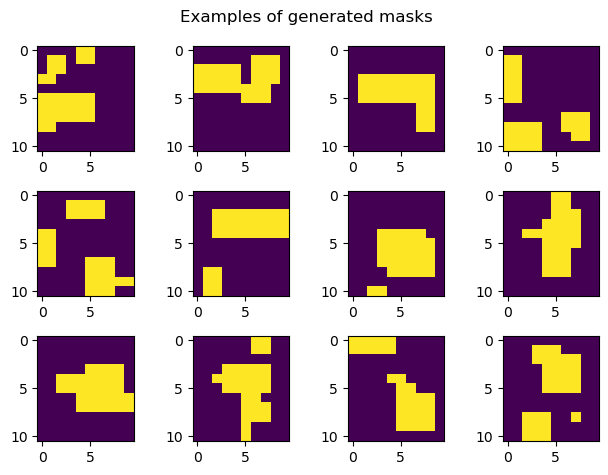

In [6]:
import sys

sys.path.insert(0, "..")
from dinov2.data.masking import MaskingGenerator
import matplotlib.pyplot as plt
import numpy as np

img_size_x = 140
img_size_y = 154
patch_size = 14
mask_generator = MaskingGenerator(
    input_size=(img_size_y // patch_size, img_size_x // patch_size),
    max_num_patches=0.5 * img_size_y // patch_size * img_size_x // patch_size,
)

f, a = plt.subplots(3, 4)
plt.suptitle("Examples of generated masks")
for i in range(12):
    m1 = mask_generator(num_masking_patches=30)
    a[i // 4, i % 4].imshow(m1)
plt.tight_layout()
plt.show()

In [7]:

def list_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

data_loader = make_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=0,
    drop_last=True,
    collate_fn=list_collate,
)

img_size = 224
patch_size = 14
mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

In [8]:
model = DinoVisionTransformer(
    patch_size=14,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    block_fn=partial(Block, attn_class=MemEffAttention),
    num_register_tokens=0,
    img_size=224,
    in_chans=3,
    drop_path_rate=0.0,
    drop_path_uniform=True,
    init_values=1.0e-05,  # for layerscale: None or 0 => no layerscale
    embed_layer=PatchEmbed,
    ffn_layer="mlp",
    block_chunks=1,
    interpolate_antialias=False,
    interpolate_offset=0.1,
)

AttributeError: 'DinoVisionTransformer' object has no attribute 'channel_embed'

In [ ]:
out = None
torch.cuda.empty_cache()
for i, el in enumerate(data_loader):
    if i > 2:
        break
    el = el[0]
    # list of len batch size containing dicts
    collated_dict = collate_data_and_cast(
        el,
        mask_ratio_tuple=(0.1, 0.5),
        mask_probability=0.5,
        dtype=torch.half,
        n_tokens=200,
        mask_generator=mask_generator,
        free_shapes=True,
    )

    model.cuda()
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            out = model(
                [
                    collated_dict["collated_global_crops"].cuda(),
                    collated_dict["collated_local_crops"].cuda(),
                ],
                masks=[collated_dict["collated_masks"].cuda(), None],
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )
            print(out[0]["x_norm_clstoken"].shape)


torch.Size([32, 384])
torch.Size([32, 384])
torch.Size([32, 384])


In [ ]:
for i in range(len(out)):
    for k in out[i].keys():
        if out[i][k] is not None:
            print(k, out[i][k].shape)

x_norm_clstoken torch.Size([32, 384])
x_norm_regtokens torch.Size([32, 0, 384])
x_norm_patchtokens torch.Size([32, 288, 384])
x_prenorm torch.Size([32, 289, 384])
masks torch.Size([32, 288])
x_norm_clstoken torch.Size([16, 384])
x_norm_regtokens torch.Size([16, 0, 384])
x_norm_patchtokens torch.Size([16, 288, 384])
x_prenorm torch.Size([16, 289, 384])


In [ ]:
import matplotlib.image as mpimg
from datetime import datetime

path_img = "/home/jluesch/Documents/data/examples/h_and_e_slide_ex.jpg"
img = mpimg.imread(path_img)
img.shape

(517, 735, 3)

In [ ]:
from kornia.augmentation import random_generator as rg

pg = rg.ColorJiggleGenerator(brightness=0.2, contrast=0.4, saturation=0.1, hue=0.2)

pg.forward((10, 65, 3))

{'brightness_factor': tensor([0.8702, 0.8959, 1.1648, 1.0605, 0.9812, 1.0418, 1.0535, 0.9883, 1.0431,
         0.9267]),
 'contrast_factor': tensor([0.7661, 1.2256, 1.3848, 1.2072, 1.1809, 1.2155, 1.3693, 1.2359, 0.7854,
         1.0523]),
 'hue_factor': tensor([-0.0729,  0.0801,  0.1894, -0.1875, -0.1675,  0.1018,  0.1812, -0.1449,
         -0.0760, -0.1944]),
 'saturation_factor': tensor([1.0278, 1.0303, 0.9131, 1.0896, 1.0026, 1.0633, 1.0676, 1.0383, 1.0724,
         0.9968]),
 'order': tensor([0, 2, 1, 3])}

torch.float32 tensor(1.) tensor(0.)
image shape torch.Size([196, 266, 3])
torch.Size([52136, 3])
FZ:  0:00:00.047269
quick #4


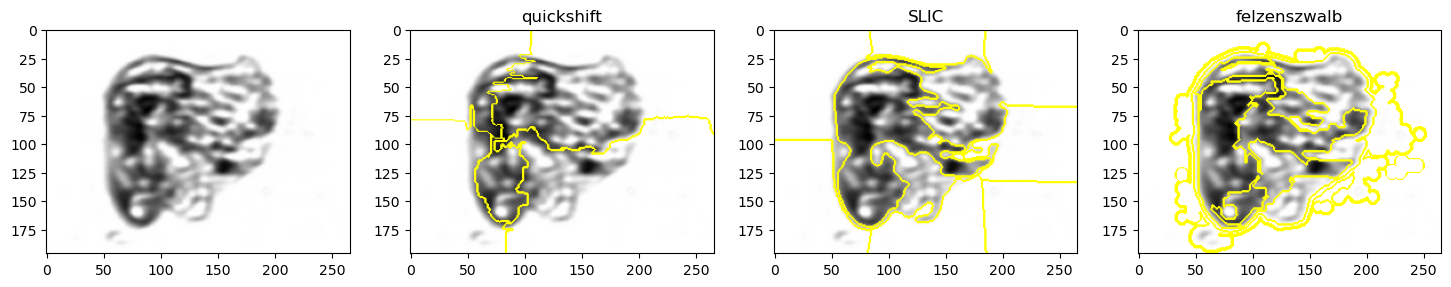

In [ ]:
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb, slic, quickshift
from skimage.segmentation import mark_boundaries
import torchvision
from torchvision.transforms.functional import InterpolationMode

img = dataset[1][0]["global_crops"][0]

if not torch.is_tensor(img):
    img = torch.tensor(img)

# img = imgs["global_crops"][0]
img = (img - img.min()) / (img.max() - img.min())
print(img.dtype, img.max(), img.min())
img = (img * 255).to(torch.uint8)
img_gray = img[0, :, :]

if img.size(0) == 3:
    img = img.permute((1, 2, 0))

orig_img_dims = img.shape[:2]
print(f"image shape {img.shape}")

grid_x, grid_y = torch.meshgrid(
    torch.arange(img_gray.size(0)), torch.arange(img_gray.size(1)), indexing="ij"
)
grid_x = (grid_x - torch.min(grid_x)) / (torch.max(grid_x) - torch.min(grid_x)) * 2
grid_y = (grid_y - torch.min(grid_y)) / (torch.max(grid_y) - torch.min(grid_y)) * 2

preprocessed_data = torch.stack([img_gray, grid_x, grid_y], dim=2).flatten(0, -2)
print(preprocessed_data.size())

segments_quick = quickshift(img, kernel_size=20, max_dist=15, ratio=0.5)
segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
start_t = datetime.now()
segments_fz = felzenszwalb(img, scale=300, sigma=0.5, min_size=700)
delta_fz = datetime.now() - start_t
print('FZ: ', delta_fz)

# saved args
# segments_quick = quickshift(img, kernel_size=7, max_dist=7, ratio=0.5)
# segments_slic = slic(img, n_segments=10, compactness=10, sigma=1.0, start_label=1)
# segments_fz = felzenszwalb(img, scale=150, sigma=0.5, min_size=150)

print(f"quick #{segments_quick.max()}")

kmeans_op = KMeans(n_clusters=10)
res = kmeans_op.fit_predict(preprocessed_data)
img_labels = res.reshape(img_gray.size())

n_plots = 4
f, a = plt.subplots(1, n_plots)
f.set_size_inches(18, 6)
a[0].imshow(img)
a[1].imshow(mark_boundaries(np.array(img), segments_quick))
a[1].set_title("quickshift")
a[2].imshow(mark_boundaries(np.array(img), segments_slic))
a[2].set_title("SLIC")
a[3].imshow(mark_boundaries(np.array(img), segments_fz))
a[3].set_title("felzenszwalb")

# a[4].imshow(img_labels)
# a[4].imshow(mark_boundaries(np.array(img), img_labels))
# for i in range(4, n_plots):
#    a[i].imshow(mark_boundaries(np.array(img), segments_quick == i))

plt.savefig("segmentations.jpg", dpi=200)
plt.show()

In [ ]:
patch_size = 14
local_crop_size = 224
maxpool_op = torch.nn.MaxPool2d(
    kernel_size=patch_size,
    stride=patch_size,
    padding=0,
    dilation=1,
    return_indices=False,
)

# Not used
unpool_op = torch.nn.MaxUnpool2d(kernel_size=patch_size, stride=patch_size, padding=0)

resize_op = torchvision.transforms.Resize(
    orig_img_dims, interpolation=InterpolationMode.NEAREST_EXACT, antialias=False
)

In [ ]:
def seg_to_patched_seg(segments):
    segments = segments / segments.max()
    conv_input = torch.tensor(segments[None, :, :])
    pooled_seg = maxpool_op(conv_input)

    resized_masks = resize_op(pooled_seg)[0, :, :]
    print(np.unique(resized_masks))
    resized_masks_int = (resized_masks * len(np.unique(resized_masks))).to(torch.int32)

    # map tensor to continuous int values
    unique_vals = torch.unique(resized_masks_int)
    lt = torch.full((int(resized_masks_int.max()) + 1,), -1)
    lt[unique_vals] = torch.arange(len(unique_vals))
    resized_masks_int = lt[resized_masks_int]

    return pooled_seg, resized_masks_int

SLIC torch.Size([196, 266, 3])
[0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
# Masks [0 1 2 3 4 5 6 7]
1 7
bbox tensor([ 70.,   0., 181.,  27.])
2 7
bbox tensor([140.,   0., 265.,  97.])
3 7
bbox tensor([ 42.,  14., 167., 167.])


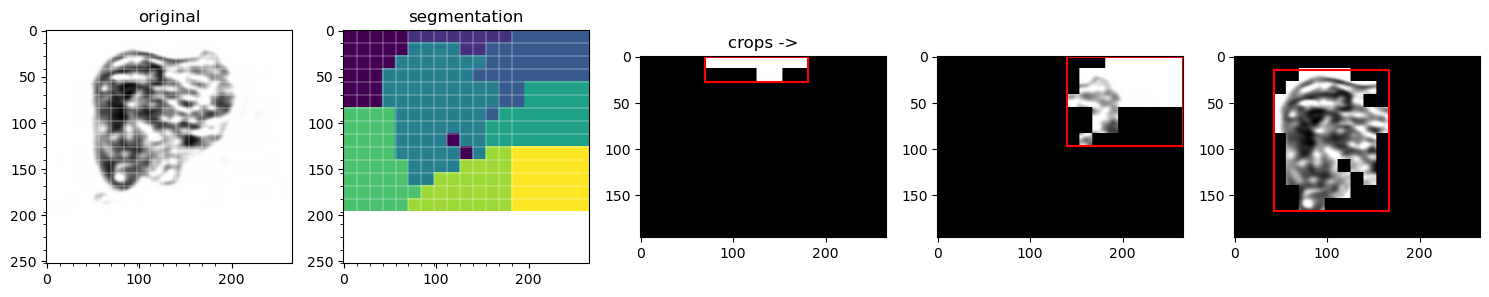

Quickshift torch.Size([196, 266, 3])
[0.   0.25 0.5  0.75 1.  ]
# Masks [0 1 2 3 4]
1 4
bbox tensor([ 56.,   0., 265.,  97.])
2 4
bbox tensor([ 70., 112.,  97., 153.])
3 4
bbox tensor([ 84.,  70., 265., 195.])


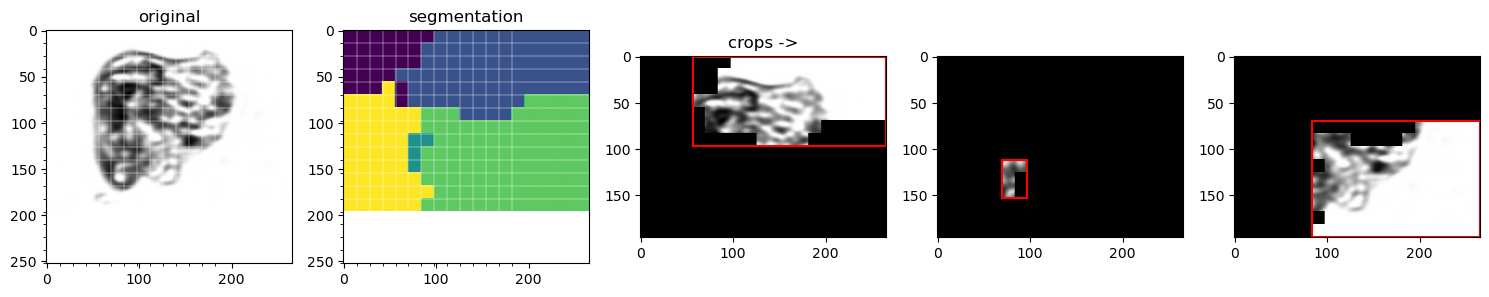

Felzenschwalb torch.Size([196, 266, 3])
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
# Masks [0 1 2 3 4 5 6 7 8]
1 8
bbox tensor([ 28.,   0., 251., 153.])
2 8
bbox tensor([ 28.,   0., 251., 195.])
3 8
bbox tensor([ 42.,  14., 209., 181.])


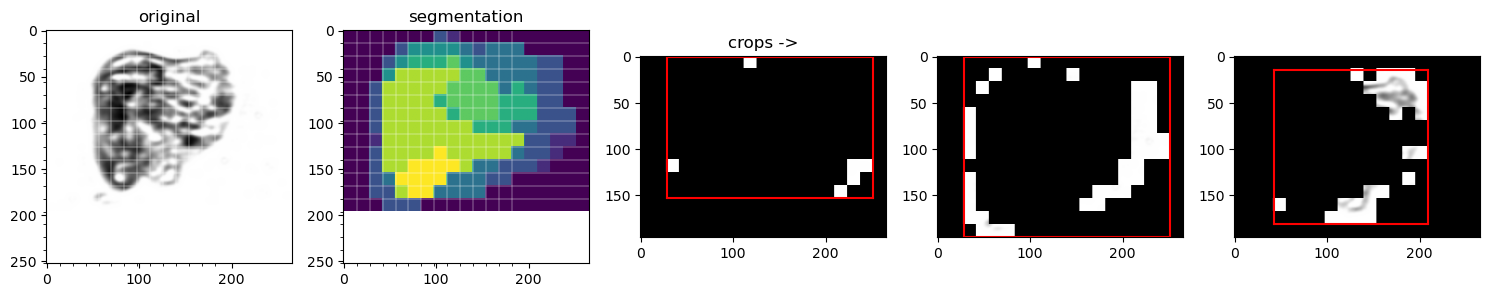

In [ ]:
from torchvision.ops import masks_to_boxes

for seg, name in zip(
    [segments_slic, segments_quick, segments_fz],
    ["SLIC", "Quickshift", "Felzenschwalb"],
):
    print(name, img.shape)
    pooled_seg, resized_masks_int = seg_to_patched_seg(seg)

    max_mask_idx = max(np.unique(resized_masks_int))
    print(f"# Masks {(np.unique(resized_masks_int))}")

    n_plots = 5
    f, a = plt.subplots(1, n_plots)
    f.set_size_inches(15, 7)
    a[0].set_title("original")
    a[1].set_title("segmentation")
    a[2].set_title("crops ->")

    a[0].imshow(img)
    a[0].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[0].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[0].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    bigger_img = pooled_seg.repeat_interleave(14, dim=1).repeat_interleave(14, dim=2)
    # Alternative
    # a[1].imshow(resize_op(pooled_seg)[0, :, :])
    a[1].imshow(bigger_img[0, :, :])
    a[1].set_xticks(np.arange(0, img.shape[0], 14), minor=True)
    a[1].set_yticks(np.arange(0, img.shape[1], 14), minor=True)
    a[1].grid(which="minor", color="w", linestyle="-", linewidth=0.3)

    img_gray = img[:, :, :1]
    for i in range(2, n_plots):
        mask_idx = i - 1
        print(mask_idx, max_mask_idx)
        if mask_idx > max_mask_idx:
            break
        fragment = torch.zeros(img_gray.shape, dtype=torch.uint8)
        mask_pos = resized_masks_int == mask_idx
        fragment[mask_pos] = img_gray[mask_pos]
        bbox = masks_to_boxes(mask_pos[None, :, :])[0]
        print("bbox", bbox)
        fragment[mask_pos] = fragment[mask_pos]
        a[i].imshow(fragment.repeat([1, 1, 3]))
        a[i].plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], "r-")
        a[i].plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], "r-")
        a[i].plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], "r-")
        a[i].plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], "r-")

    f.tight_layout()
    plt.savefig(f"seg_examples_{name}.jpg", dpi=200, bbox_inches="tight")
    plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=100, algorithm="ball_tree").fit(preprocessed_data)
distances, indices = nbrs.kneighbors()

In [ ]:
img_labels = torch.zeros(indices.shape[0])

for i in range(indices.shape[0]):
    nbhs = indices[i, :]
    img_labels[nbhs] = i

img_labels = img_labels.reshape(img.size())

RuntimeError: shape '[196, 266, 3]' is invalid for input of size 52136

In [ ]:
plt.imshow(img_labels)
plt.legend(img_labels)
plt.show()